In [145]:
import numpy as np
from scipy.integrate import solve_ivp

In [146]:
# constants #

ki = 1.2e-06 # 1/s
kp = 6500 # L/mol*s
ktc = 6e06 # L/mol*s
ktd = 6e06 # L/mol*s
kfm = 9.1e-02 # L/mol*s
kfp = 0.5 # L/mol*s
kpp = 0.05 # L/mol*s
f = 1.0
M0 = 8.43 # mol/L
I0 = 0.002 #mol/L

In [147]:
def lambda_0(I): # moment zero for radicals
    return np.sqrt((2 * f * ki * I) / ktd)

def lambda_1(M, L0, mu_1, mu_2): # momento one for radicals
    num = kp * M * L0 + kfp * L0 * mu_2
    denm = kfm * M + ktd * L0 + kfp * mu_1
    
    return num / denm

In [148]:
# Crear un array de 400 valores para n
n = np.arange(1, 401) * 2500  # Va de 1*2500 a 400*2500

# Crear un array con 400 elementos para b
b = 1.0 / np.diff(n)
b = np.append(b, b[-1])

In [149]:
b

array([0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
      

In [150]:
# Función principal
def balances_KR(t, y):
    # Descomposición del vector de estados
    I = y[0]
    M = y[1]
    mu_0 = y[2]
    mu_1 = y[3]
    mu_2 = y[4]
    Nrd = y[5:405]  # Radicales
    Npd = y[405:805]  # Polímeros

    # Cálculo de momentos de los radicales
    L0 = lambda_0(I)
    L1 = lambda_1(M, L0, mu_1, mu_2)

    # Ecuaciones diferenciales
    dIdt = -ki * I
    dMdt = -(kp + kfm) * M * L0
    dmu_0dt = kfm * M * L0 + ktd * L0**2
    dmu_1dt = kp * M * L0
    dmu_2dt = kp * M * (L0 + 2 * L1)

    # Ecuaciones para los radicales y polímeros
    dNrdt = np.zeros_like(Nrd)
    dNpdt = np.zeros_like(Npd)

    for idx in range(len(Nrd)):
        if idx == 0:
            dNrdt[idx] = (- (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                          - kp * M * (b[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx]
                          + kfm * M * L0 + 2 * f * ki * I)
        else:
            dNrdt[idx] = (- (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                          + kp * M * (b[idx-1] * Nrd[idx-1] - b[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx])

    for idx in range(len(Npd)):
        dNpdt[idx] = (- kfp * L0 * n[idx] * Npd[idx]
                      + (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx])

    # Concatenación de derivadas
    return np.concatenate(([dIdt, dMdt, dmu_0dt, dmu_1dt, dmu_2dt], dNrdt, dNpdt))

In [151]:
y0 = np.zeros(805)
y0[0] = I0
y0[1] = M0

time = [0, 40000]

In [152]:
sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      method='LSODA',
      rtol=1e-06,
      atol=1e-09
      )

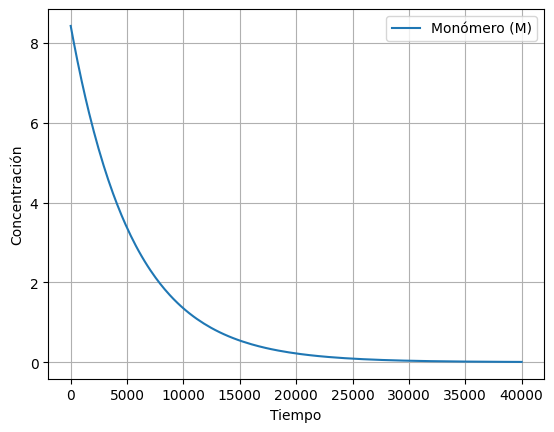

In [153]:
# Visualización
import matplotlib.pyplot as plt

#plt.plot(sol.t, sol.y[0], label="Iniciador (I)")
plt.plot(sol.t, sol.y[1], label="Monómero (M)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Concentración")
plt.grid()
plt.show()

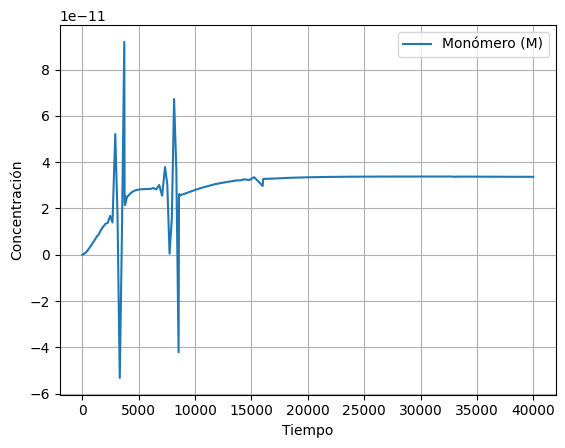

In [154]:
#plt.plot(sol.t, sol.y[0], label="Iniciador (I)")
plt.plot(sol.t, sol.y[250], label="Monómero (M)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Concentración")
plt.grid()
plt.show()

In [155]:
(8.4-3.2)/8.4

0.6190476190476191

In [156]:
sol.t.shape

(206,)

1.8263966317833358

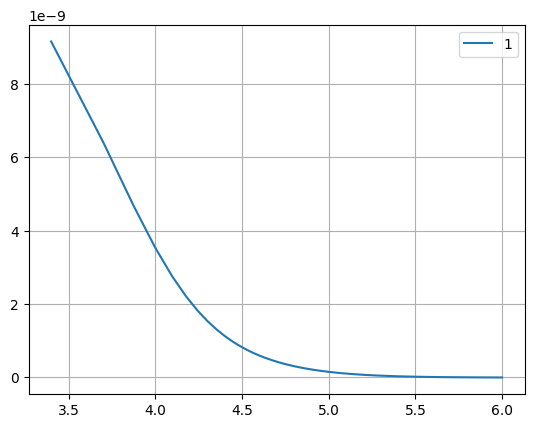

In [162]:
nlog = np.log10(n)
pn1 = sol.y[405:805, 100] / (1/b)

pn1n = np.multiply(pn1, n)

plt.plot(nlog, pn1, label='1')
#plt.plot(nlog, pn2, label='2')
#plt.plot(nlog, pn3, label='3')
plt.grid()
plt.legend()

sol.y[1][100]


In [158]:
n[370]

927500